# Afriat

In [1]:
ood_seed = 19

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('36', 'Periportal', 'Infected')


Removed datapoint: 719

train         14741
validation     3593
ood             719
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 56%|█████▌    | 10622/19053 [00:00<00:00, 106216.30it/s]

100%|██████████| 19053/19053 [00:00<00:00, 106717.15it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1113335.02it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 428.73it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:09<1:00:53,  9.16s/it]

Epoch 1/400:   0%|          | 1/400 [00:09<1:00:53,  9.16s/it, v_num=1, recon=3.94e+3, r2_mean=0.202, adv_loss=3.33, acc_pert=0.241, acc_zone=0.717, acc_status_control=0.498]

Epoch 2/400:   0%|          | 1/400 [00:09<1:00:53,  9.16s/it, v_num=1, recon=3.94e+3, r2_mean=0.202, adv_loss=3.33, acc_pert=0.241, acc_zone=0.717, acc_status_control=0.498]

Epoch 2/400:   0%|          | 2/400 [00:17<59:00,  8.90s/it, v_num=1, recon=3.94e+3, r2_mean=0.202, adv_loss=3.33, acc_pert=0.241, acc_zone=0.717, acc_status_control=0.498]  

Epoch 2/400:   0%|          | 2/400 [00:17<59:00,  8.90s/it, v_num=1, recon=3.23e+3, r2_mean=0.611, adv_loss=2.86, acc_pert=0.338, acc_zone=0.81, acc_status_control=0.661] 

Epoch 3/400:   0%|          | 2/400 [00:17<59:00,  8.90s/it, v_num=1, recon=3.23e+3, r2_mean=0.611, adv_loss=2.86, acc_pert=0.338, acc_zone=0.81, acc_status_control=0.661]

Epoch 3/400:   1%|          | 3/400 [00:26<58:32,  8.85s/it, v_num=1, recon=3.23e+3, r2_mean=0.611, adv_loss=2.86, acc_pert=0.338, acc_zone=0.81, acc_status_control=0.661]

Epoch 3/400:   1%|          | 3/400 [00:26<58:32,  8.85s/it, v_num=1, recon=3.17e+3, r2_mean=0.713, adv_loss=2.72, acc_pert=0.381, acc_zone=0.822, acc_status_control=0.651]

Epoch 4/400:   1%|          | 3/400 [00:26<58:32,  8.85s/it, v_num=1, recon=3.17e+3, r2_mean=0.713, adv_loss=2.72, acc_pert=0.381, acc_zone=0.822, acc_status_control=0.651]

Epoch 4/400:   1%|          | 4/400 [00:35<58:21,  8.84s/it, v_num=1, recon=3.17e+3, r2_mean=0.713, adv_loss=2.72, acc_pert=0.381, acc_zone=0.822, acc_status_control=0.651]

Epoch 4/400:   1%|          | 4/400 [00:35<58:21,  8.84s/it, v_num=1, recon=3.15e+3, r2_mean=0.749, adv_loss=2.62, acc_pert=0.445, acc_zone=0.826, acc_status_control=0.641]

Epoch 5/400:   1%|          | 4/400 [00:35<58:21,  8.84s/it, v_num=1, recon=3.15e+3, r2_mean=0.749, adv_loss=2.62, acc_pert=0.445, acc_zone=0.826, acc_status_control=0.641]

Epoch 5/400:   1%|▏         | 5/400 [00:44<58:09,  8.83s/it, v_num=1, recon=3.15e+3, r2_mean=0.749, adv_loss=2.62, acc_pert=0.445, acc_zone=0.826, acc_status_control=0.641]

Epoch 5/400:   1%|▏         | 5/400 [00:44<58:09,  8.83s/it, v_num=1, recon=3.14e+3, r2_mean=0.77, adv_loss=2.46, acc_pert=0.512, acc_zone=0.83, acc_status_control=0.643]  

Epoch 6/400:   1%|▏         | 5/400 [00:44<58:09,  8.83s/it, v_num=1, recon=3.14e+3, r2_mean=0.77, adv_loss=2.46, acc_pert=0.512, acc_zone=0.83, acc_status_control=0.643]

Epoch 6/400:   2%|▏         | 6/400 [00:53<58:01,  8.84s/it, v_num=1, recon=3.14e+3, r2_mean=0.77, adv_loss=2.46, acc_pert=0.512, acc_zone=0.83, acc_status_control=0.643]

Epoch 6/400:   2%|▏         | 6/400 [00:53<58:01,  8.84s/it, v_num=1, recon=3.13e+3, r2_mean=0.788, adv_loss=2.32, acc_pert=0.556, acc_zone=0.83, acc_status_control=0.644]

Epoch 7/400:   2%|▏         | 6/400 [00:53<58:01,  8.84s/it, v_num=1, recon=3.13e+3, r2_mean=0.788, adv_loss=2.32, acc_pert=0.556, acc_zone=0.83, acc_status_control=0.644]

Epoch 7/400:   2%|▏         | 7/400 [01:01<57:53,  8.84s/it, v_num=1, recon=3.13e+3, r2_mean=0.788, adv_loss=2.32, acc_pert=0.556, acc_zone=0.83, acc_status_control=0.644]

Epoch 7/400:   2%|▏         | 7/400 [01:01<57:53,  8.84s/it, v_num=1, recon=3.12e+3, r2_mean=0.796, adv_loss=2.2, acc_pert=0.595, acc_zone=0.827, acc_status_control=0.646]

Epoch 8/400:   2%|▏         | 7/400 [01:01<57:53,  8.84s/it, v_num=1, recon=3.12e+3, r2_mean=0.796, adv_loss=2.2, acc_pert=0.595, acc_zone=0.827, acc_status_control=0.646]

Epoch 8/400:   2%|▏         | 8/400 [01:10<57:35,  8.82s/it, v_num=1, recon=3.12e+3, r2_mean=0.796, adv_loss=2.2, acc_pert=0.595, acc_zone=0.827, acc_status_control=0.646]

Epoch 8/400:   2%|▏         | 8/400 [01:10<57:35,  8.82s/it, v_num=1, recon=3.11e+3, r2_mean=0.802, adv_loss=2.09, acc_pert=0.631, acc_zone=0.84, acc_status_control=0.642]

Epoch 9/400:   2%|▏         | 8/400 [01:10<57:35,  8.82s/it, v_num=1, recon=3.11e+3, r2_mean=0.802, adv_loss=2.09, acc_pert=0.631, acc_zone=0.84, acc_status_control=0.642]

Epoch 9/400:   2%|▏         | 9/400 [01:19<57:28,  8.82s/it, v_num=1, recon=3.11e+3, r2_mean=0.802, adv_loss=2.09, acc_pert=0.631, acc_zone=0.84, acc_status_control=0.642]

Epoch 9/400:   2%|▏         | 9/400 [01:19<57:28,  8.82s/it, v_num=1, recon=3.1e+3, r2_mean=0.808, adv_loss=2.07, acc_pert=0.645, acc_zone=0.846, acc_status_control=0.645]

Epoch 10/400:   2%|▏         | 9/400 [01:19<57:28,  8.82s/it, v_num=1, recon=3.1e+3, r2_mean=0.808, adv_loss=2.07, acc_pert=0.645, acc_zone=0.846, acc_status_control=0.645]


disnt_basal = 1.2438197810995317

disnt_after = 1.8646637458932025

val_r2_mean = 0.8051300624025635

val_r2_var = 0.20116671256339716


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:32<1:06:19, 10.20s/it, v_num=1, recon=3.1e+3, r2_mean=0.808, adv_loss=2.07, acc_pert=0.645, acc_zone=0.846, acc_status_control=0.645]

Epoch 10/400:   2%|▎         | 10/400 [01:32<1:06:19, 10.20s/it, v_num=1, recon=3.1e+3, r2_mean=0.809, adv_loss=2.1, acc_pert=0.642, acc_zone=0.844, acc_status_control=0.643, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:32<1:06:19, 10.20s/it, v_num=1, recon=3.1e+3, r2_mean=0.809, adv_loss=2.1, acc_pert=0.642, acc_zone=0.844, acc_status_control=0.643, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:41<1:03:20,  9.77s/it, v_num=1, recon=3.1e+3, r2_mean=0.809, adv_loss=2.1, acc_pert=0.642, acc_zone=0.844, acc_status_control=0.643, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:41<1:03:20,  9.77s/it, v_num=1, recon=3.09e+3, r2_mean=0.814, adv_loss=2.02, acc_pert=0.668, acc_zone=0.844, acc_status_control=0.65, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [01:41<1:03:20,  9.77s/it, v_num=1, recon=3.09e+3, r2_mean=0.814, adv_loss=2.02, acc_pert=0.668, acc_zone=0.844, acc_status_control=0.65, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:50<1:01:17,  9.48s/it, v_num=1, recon=3.09e+3, r2_mean=0.814, adv_loss=2.02, acc_pert=0.668, acc_zone=0.844, acc_status_control=0.65, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:50<1:01:17,  9.48s/it, v_num=1, recon=3.08e+3, r2_mean=0.816, adv_loss=1.97, acc_pert=0.68, acc_zone=0.846, acc_status_control=0.657, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [01:50<1:01:17,  9.48s/it, v_num=1, recon=3.08e+3, r2_mean=0.816, adv_loss=1.97, acc_pert=0.68, acc_zone=0.846, acc_status_control=0.657, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:59<59:43,  9.26s/it, v_num=1, recon=3.08e+3, r2_mean=0.816, adv_loss=1.97, acc_pert=0.68, acc_zone=0.846, acc_status_control=0.657, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]  

Epoch 13/400:   3%|▎         | 13/400 [01:59<59:43,  9.26s/it, v_num=1, recon=3.08e+3, r2_mean=0.817, adv_loss=1.99, acc_pert=0.677, acc_zone=0.847, acc_status_control=0.647, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [01:59<59:43,  9.26s/it, v_num=1, recon=3.08e+3, r2_mean=0.817, adv_loss=1.99, acc_pert=0.677, acc_zone=0.847, acc_status_control=0.647, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:08<58:35,  9.11s/it, v_num=1, recon=3.08e+3, r2_mean=0.817, adv_loss=1.99, acc_pert=0.677, acc_zone=0.847, acc_status_control=0.647, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:08<58:35,  9.11s/it, v_num=1, recon=3.08e+3, r2_mean=0.817, adv_loss=2.01, acc_pert=0.668, acc_zone=0.845, acc_status_control=0.647, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:08<58:35,  9.11s/it, v_num=1, recon=3.08e+3, r2_mean=0.817, adv_loss=2.01, acc_pert=0.668, acc_zone=0.845, acc_status_control=0.647, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:16<57:45,  9.00s/it, v_num=1, recon=3.08e+3, r2_mean=0.817, adv_loss=2.01, acc_pert=0.668, acc_zone=0.845, acc_status_control=0.647, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:16<57:45,  9.00s/it, v_num=1, recon=3.07e+3, r2_mean=0.818, adv_loss=1.98, acc_pert=0.678, acc_zone=0.852, acc_status_control=0.652, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [02:16<57:45,  9.00s/it, v_num=1, recon=3.07e+3, r2_mean=0.818, adv_loss=1.98, acc_pert=0.678, acc_zone=0.852, acc_status_control=0.652, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:25<57:08,  8.93s/it, v_num=1, recon=3.07e+3, r2_mean=0.818, adv_loss=1.98, acc_pert=0.678, acc_zone=0.852, acc_status_control=0.652, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:25<57:08,  8.93s/it, v_num=1, recon=3.07e+3, r2_mean=0.82, adv_loss=1.99, acc_pert=0.672, acc_zone=0.849, acc_status_control=0.649, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan] 

Epoch 17/400:   4%|▍         | 16/400 [02:25<57:08,  8.93s/it, v_num=1, recon=3.07e+3, r2_mean=0.82, adv_loss=1.99, acc_pert=0.672, acc_zone=0.849, acc_status_control=0.649, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:34<56:33,  8.86s/it, v_num=1, recon=3.07e+3, r2_mean=0.82, adv_loss=1.99, acc_pert=0.672, acc_zone=0.849, acc_status_control=0.649, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:34<56:33,  8.86s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=1.99, acc_pert=0.679, acc_zone=0.848, acc_status_control=0.651, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [02:34<56:33,  8.86s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=1.99, acc_pert=0.679, acc_zone=0.848, acc_status_control=0.651, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:43<56:17,  8.84s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=1.99, acc_pert=0.679, acc_zone=0.848, acc_status_control=0.651, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:43<56:17,  8.84s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=1.99, acc_pert=0.674, acc_zone=0.85, acc_status_control=0.655, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan] 

Epoch 19/400:   4%|▍         | 18/400 [02:43<56:17,  8.84s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=1.99, acc_pert=0.674, acc_zone=0.85, acc_status_control=0.655, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:51<56:09,  8.84s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=1.99, acc_pert=0.674, acc_zone=0.85, acc_status_control=0.655, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:51<56:09,  8.84s/it, v_num=1, recon=3.06e+3, r2_mean=0.822, adv_loss=1.96, acc_pert=0.684, acc_zone=0.85, acc_status_control=0.659, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [02:51<56:09,  8.84s/it, v_num=1, recon=3.06e+3, r2_mean=0.822, adv_loss=1.96, acc_pert=0.684, acc_zone=0.85, acc_status_control=0.659, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]


disnt_basal = 1.2529541273393623

disnt_after = 1.838314757939809

val_r2_mean = 0.8219698511515705

val_r2_var = 0.22872169815124732

Epoch 20/400:   5%|▌         | 20/400 [03:05<1:04:28, 10.18s/it, v_num=1, recon=3.06e+3, r2_mean=0.822, adv_loss=1.96, acc_pert=0.684, acc_zone=0.85, acc_status_control=0.659, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.805, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [03:05<1:04:28, 10.18s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.95, acc_pert=0.687, acc_zone=0.849, acc_status_control=0.662, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [03:05<1:04:28, 10.18s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.95, acc_pert=0.687, acc_zone=0.849, acc_status_control=0.662, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:13<1:01:24,  9.72s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.95, acc_pert=0.687, acc_zone=0.849, acc_status_control=0.662, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:13<1:01:24,  9.72s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.97, acc_pert=0.677, acc_zone=0.854, acc_status_control=0.656, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [03:13<1:01:24,  9.72s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.97, acc_pert=0.677, acc_zone=0.854, acc_status_control=0.656, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:22<59:21,  9.42s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.97, acc_pert=0.677, acc_zone=0.854, acc_status_control=0.656, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]  

Epoch 22/400:   6%|▌         | 22/400 [03:22<59:21,  9.42s/it, v_num=1, recon=3.04e+3, r2_mean=0.824, adv_loss=1.96, acc_pert=0.674, acc_zone=0.852, acc_status_control=0.66, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan] 

Epoch 23/400:   6%|▌         | 22/400 [03:22<59:21,  9.42s/it, v_num=1, recon=3.04e+3, r2_mean=0.824, adv_loss=1.96, acc_pert=0.674, acc_zone=0.852, acc_status_control=0.66, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:31<57:55,  9.22s/it, v_num=1, recon=3.04e+3, r2_mean=0.824, adv_loss=1.96, acc_pert=0.674, acc_zone=0.852, acc_status_control=0.66, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:31<57:55,  9.22s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=1.99, acc_pert=0.665, acc_zone=0.85, acc_status_control=0.661, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [03:31<57:55,  9.22s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=1.99, acc_pert=0.665, acc_zone=0.85, acc_status_control=0.661, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:40<56:51,  9.07s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=1.99, acc_pert=0.665, acc_zone=0.85, acc_status_control=0.661, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:40<56:51,  9.07s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=1.99, acc_pert=0.667, acc_zone=0.845, acc_status_control=0.663, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [03:40<56:51,  9.07s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=1.99, acc_pert=0.667, acc_zone=0.845, acc_status_control=0.663, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:48<55:59,  8.96s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=1.99, acc_pert=0.667, acc_zone=0.845, acc_status_control=0.663, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:48<55:59,  8.96s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=1.97, acc_pert=0.671, acc_zone=0.846, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [03:48<55:59,  8.96s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=1.97, acc_pert=0.671, acc_zone=0.846, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [03:57<55:27,  8.90s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=1.97, acc_pert=0.671, acc_zone=0.846, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [03:57<55:27,  8.90s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=1.98, acc_pert=0.666, acc_zone=0.844, acc_status_control=0.666, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [03:57<55:27,  8.90s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=1.98, acc_pert=0.666, acc_zone=0.844, acc_status_control=0.666, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:06<55:15,  8.89s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=1.98, acc_pert=0.666, acc_zone=0.844, acc_status_control=0.666, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:06<55:15,  8.89s/it, v_num=1, recon=3.03e+3, r2_mean=0.827, adv_loss=2.01, acc_pert=0.659, acc_zone=0.844, acc_status_control=0.659, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [04:06<55:15,  8.89s/it, v_num=1, recon=3.03e+3, r2_mean=0.827, adv_loss=2.01, acc_pert=0.659, acc_zone=0.844, acc_status_control=0.659, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:15<54:52,  8.85s/it, v_num=1, recon=3.03e+3, r2_mean=0.827, adv_loss=2.01, acc_pert=0.659, acc_zone=0.844, acc_status_control=0.659, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:15<54:52,  8.85s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.655, acc_zone=0.845, acc_status_control=0.667, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]    

Epoch 29/400:   7%|▋         | 28/400 [04:15<54:52,  8.85s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.655, acc_zone=0.845, acc_status_control=0.667, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:23<54:36,  8.83s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.655, acc_zone=0.845, acc_status_control=0.667, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:23<54:36,  8.83s/it, v_num=1, recon=3.02e+3, r2_mean=0.828, adv_loss=2, acc_pert=0.659, acc_zone=0.844, acc_status_control=0.666, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [04:23<54:36,  8.83s/it, v_num=1, recon=3.02e+3, r2_mean=0.828, adv_loss=2, acc_pert=0.659, acc_zone=0.844, acc_status_control=0.666, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]


disnt_basal = 1.2426861056505036

disnt_after = 1.8362324305835849

val_r2_mean = 0.8258885989726884

val_r2_var = 0.24781317869164549

Epoch 30/400:   8%|▊         | 30/400 [04:37<1:02:43, 10.17s/it, v_num=1, recon=3.02e+3, r2_mean=0.828, adv_loss=2, acc_pert=0.659, acc_zone=0.844, acc_status_control=0.666, val_recon=3.09e+3, disnt_basal=1.25, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [04:37<1:02:43, 10.17s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.654, acc_zone=0.847, acc_status_control=0.673, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 31/400:   8%|▊         | 30/400 [04:37<1:02:43, 10.17s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.654, acc_zone=0.847, acc_status_control=0.673, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [04:45<59:56,  9.75s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.654, acc_zone=0.847, acc_status_control=0.673, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]  

Epoch 31/400:   8%|▊         | 31/400 [04:45<59:56,  9.75s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=2.01, acc_pert=0.65, acc_zone=0.849, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [04:45<59:56,  9.75s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=2.01, acc_pert=0.65, acc_zone=0.849, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [04:54<57:55,  9.44s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=2.01, acc_pert=0.65, acc_zone=0.849, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [04:54<57:55,  9.44s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.02, acc_pert=0.65, acc_zone=0.844, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [04:54<57:55,  9.44s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.02, acc_pert=0.65, acc_zone=0.844, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:03<56:32,  9.25s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.02, acc_pert=0.65, acc_zone=0.844, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:03<56:32,  9.25s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.03, acc_pert=0.646, acc_zone=0.842, acc_status_control=0.666, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [05:03<56:32,  9.25s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.03, acc_pert=0.646, acc_zone=0.842, acc_status_control=0.666, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:12<55:33,  9.11s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.03, acc_pert=0.646, acc_zone=0.842, acc_status_control=0.666, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:12<55:33,  9.11s/it, v_num=1, recon=3.01e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.642, acc_zone=0.844, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [05:12<55:33,  9.11s/it, v_num=1, recon=3.01e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.642, acc_zone=0.844, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:20<54:45,  9.00s/it, v_num=1, recon=3.01e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.642, acc_zone=0.844, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:20<54:45,  9.00s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=2.04, acc_pert=0.642, acc_zone=0.844, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]   

Epoch 36/400:   9%|▉         | 35/400 [05:20<54:45,  9.00s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=2.04, acc_pert=0.642, acc_zone=0.844, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:29<54:06,  8.92s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=2.04, acc_pert=0.642, acc_zone=0.844, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:29<54:06,  8.92s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.04, acc_pert=0.641, acc_zone=0.845, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 37/400:   9%|▉         | 36/400 [05:29<54:06,  8.92s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.04, acc_pert=0.641, acc_zone=0.845, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:38<53:37,  8.86s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.04, acc_pert=0.641, acc_zone=0.845, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:38<53:37,  8.86s/it, v_num=1, recon=3e+3, r2_mean=0.828, adv_loss=2.07, acc_pert=0.63, acc_zone=0.843, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [05:38<53:37,  8.86s/it, v_num=1, recon=3e+3, r2_mean=0.828, adv_loss=2.07, acc_pert=0.63, acc_zone=0.843, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:47<53:16,  8.83s/it, v_num=1, recon=3e+3, r2_mean=0.828, adv_loss=2.07, acc_pert=0.63, acc_zone=0.843, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:47<53:16,  8.83s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.06, acc_pert=0.629, acc_zone=0.836, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [05:47<53:16,  8.83s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.06, acc_pert=0.629, acc_zone=0.836, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [05:55<52:59,  8.81s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.06, acc_pert=0.629, acc_zone=0.836, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [05:55<52:59,  8.81s/it, v_num=1, recon=2.99e+3, r2_mean=0.828, adv_loss=2.05, acc_pert=0.633, acc_zone=0.843, acc_status_control=0.671, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [05:55<52:59,  8.81s/it, v_num=1, recon=2.99e+3, r2_mean=0.828, adv_loss=2.05, acc_pert=0.633, acc_zone=0.843, acc_status_control=0.671, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.2371208191146454

disnt_after = 1.8305851433780258

val_r2_mean = 0.8211692647054933

val_r2_var = 0.25096787893483313

Epoch 40/400:  10%|█         | 40/400 [06:09<1:00:40, 10.11s/it, v_num=1, recon=2.99e+3, r2_mean=0.828, adv_loss=2.05, acc_pert=0.633, acc_zone=0.843, acc_status_control=0.671, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [06:09<1:00:40, 10.11s/it, v_num=1, recon=2.99e+3, r2_mean=0.829, adv_loss=2.06, acc_pert=0.635, acc_zone=0.843, acc_status_control=0.675, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [06:09<1:00:40, 10.11s/it, v_num=1, recon=2.99e+3, r2_mean=0.829, adv_loss=2.06, acc_pert=0.635, acc_zone=0.843, acc_status_control=0.675, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:17<58:00,  9.69s/it, v_num=1, recon=2.99e+3, r2_mean=0.829, adv_loss=2.06, acc_pert=0.635, acc_zone=0.843, acc_status_control=0.675, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]  

Epoch 41/400:  10%|█         | 41/400 [06:17<58:00,  9.69s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.07, acc_pert=0.63, acc_zone=0.845, acc_status_control=0.668, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]    

Epoch 42/400:  10%|█         | 41/400 [06:17<58:00,  9.69s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.07, acc_pert=0.63, acc_zone=0.845, acc_status_control=0.668, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:26<56:04,  9.40s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.07, acc_pert=0.63, acc_zone=0.845, acc_status_control=0.668, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:26<56:04,  9.40s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.06, acc_pert=0.631, acc_zone=0.842, acc_status_control=0.672, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [06:26<56:04,  9.40s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.06, acc_pert=0.631, acc_zone=0.842, acc_status_control=0.672, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:35<54:41,  9.19s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.06, acc_pert=0.631, acc_zone=0.842, acc_status_control=0.672, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:35<54:41,  9.19s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.07, acc_pert=0.626, acc_zone=0.84, acc_status_control=0.666, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan] 

Epoch 44/400:  11%|█         | 43/400 [06:35<54:41,  9.19s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.07, acc_pert=0.626, acc_zone=0.84, acc_status_control=0.666, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:43<53:41,  9.05s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.07, acc_pert=0.626, acc_zone=0.84, acc_status_control=0.666, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:43<53:41,  9.05s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.08, acc_pert=0.623, acc_zone=0.843, acc_status_control=0.67, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [06:43<53:41,  9.05s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.08, acc_pert=0.623, acc_zone=0.843, acc_status_control=0.67, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [06:52<53:04,  8.97s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.08, acc_pert=0.623, acc_zone=0.843, acc_status_control=0.67, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [06:52<53:04,  8.97s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.09, acc_pert=0.626, acc_zone=0.839, acc_status_control=0.667, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [06:52<53:04,  8.97s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.09, acc_pert=0.626, acc_zone=0.839, acc_status_control=0.667, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:01<52:27,  8.89s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.09, acc_pert=0.626, acc_zone=0.839, acc_status_control=0.667, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:01<52:27,  8.89s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.08, acc_pert=0.623, acc_zone=0.839, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [07:01<52:27,  8.89s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.08, acc_pert=0.623, acc_zone=0.839, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:10<52:14,  8.88s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.08, acc_pert=0.623, acc_zone=0.839, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:10<52:14,  8.88s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.11, acc_pert=0.607, acc_zone=0.839, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [07:10<52:14,  8.88s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.11, acc_pert=0.607, acc_zone=0.839, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:19<51:59,  8.86s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.11, acc_pert=0.607, acc_zone=0.839, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:19<51:59,  8.86s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.11, acc_pert=0.612, acc_zone=0.838, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [07:19<51:59,  8.86s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.11, acc_pert=0.612, acc_zone=0.838, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [07:27<51:40,  8.83s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.11, acc_pert=0.612, acc_zone=0.838, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [07:27<51:40,  8.83s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.1, acc_pert=0.618, acc_zone=0.836, acc_status_control=0.67, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]  

Epoch 50/400:  12%|█▏        | 49/400 [07:27<51:40,  8.83s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.1, acc_pert=0.618, acc_zone=0.836, acc_status_control=0.67, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]


disnt_basal = 1.225149552327425

disnt_after = 1.8247512850300396

val_r2_mean = 0.8272180398004769

val_r2_var = 0.2693580418023935


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [07:41<59:07, 10.14s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.1, acc_pert=0.618, acc_zone=0.836, acc_status_control=0.67, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.83, val_r2_mean=0.821, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [07:41<59:07, 10.14s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.1, acc_pert=0.615, acc_zone=0.841, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [07:41<59:07, 10.14s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.1, acc_pert=0.615, acc_zone=0.841, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [07:49<56:44,  9.75s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.1, acc_pert=0.615, acc_zone=0.841, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [07:49<56:44,  9.75s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.1, acc_pert=0.611, acc_zone=0.839, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [07:49<56:44,  9.75s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.1, acc_pert=0.611, acc_zone=0.839, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [07:58<54:52,  9.46s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.1, acc_pert=0.611, acc_zone=0.839, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [07:58<54:52,  9.46s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [07:58<54:52,  9.46s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:07<53:46,  9.30s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:07<53:46,  9.30s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.11, acc_pert=0.611, acc_zone=0.84, acc_status_control=0.668, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan] 

Epoch 54/400:  13%|█▎        | 53/400 [08:07<53:46,  9.30s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.11, acc_pert=0.611, acc_zone=0.84, acc_status_control=0.668, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:16<52:47,  9.16s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.11, acc_pert=0.611, acc_zone=0.84, acc_status_control=0.668, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:16<52:47,  9.16s/it, v_num=1, recon=2.96e+3, r2_mean=0.832, adv_loss=2.13, acc_pert=0.606, acc_zone=0.838, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [08:16<52:47,  9.16s/it, v_num=1, recon=2.96e+3, r2_mean=0.832, adv_loss=2.13, acc_pert=0.606, acc_zone=0.838, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [08:25<52:01,  9.05s/it, v_num=1, recon=2.96e+3, r2_mean=0.832, adv_loss=2.13, acc_pert=0.606, acc_zone=0.838, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [08:25<52:01,  9.05s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.608, acc_zone=0.834, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [08:25<52:01,  9.05s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.608, acc_zone=0.834, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [08:34<51:28,  8.98s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.608, acc_zone=0.834, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [08:34<51:28,  8.98s/it, v_num=1, recon=2.96e+3, r2_mean=0.832, adv_loss=2.12, acc_pert=0.609, acc_zone=0.835, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [08:34<51:28,  8.98s/it, v_num=1, recon=2.96e+3, r2_mean=0.832, adv_loss=2.12, acc_pert=0.609, acc_zone=0.835, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [08:42<50:53,  8.90s/it, v_num=1, recon=2.96e+3, r2_mean=0.832, adv_loss=2.12, acc_pert=0.609, acc_zone=0.835, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [08:42<50:53,  8.90s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.618, acc_zone=0.84, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan] 

Epoch 58/400:  14%|█▍        | 57/400 [08:42<50:53,  8.90s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.618, acc_zone=0.84, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [08:51<50:41,  8.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.618, acc_zone=0.84, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [08:51<50:41,  8.89s/it, v_num=1, recon=2.95e+3, r2_mean=0.831, adv_loss=2.11, acc_pert=0.617, acc_zone=0.839, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [08:51<50:41,  8.89s/it, v_num=1, recon=2.95e+3, r2_mean=0.831, adv_loss=2.11, acc_pert=0.617, acc_zone=0.839, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:00<50:19,  8.85s/it, v_num=1, recon=2.95e+3, r2_mean=0.831, adv_loss=2.11, acc_pert=0.617, acc_zone=0.839, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:00<50:19,  8.85s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.604, acc_zone=0.838, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [09:00<50:19,  8.85s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.604, acc_zone=0.838, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2226494729047175

disnt_after = 1.830844546259103

val_r2_mean = 0.8248577417379073

val_r2_var = 0.27893800569982946


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [09:13<57:38, 10.17s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.604, acc_zone=0.838, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [09:13<57:38, 10.17s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.14, acc_pert=0.606, acc_zone=0.836, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [09:13<57:38, 10.17s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.14, acc_pert=0.606, acc_zone=0.836, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [09:22<54:49,  9.70s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.14, acc_pert=0.606, acc_zone=0.836, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [09:22<54:49,  9.70s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.611, acc_zone=0.835, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [09:22<54:49,  9.70s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.611, acc_zone=0.835, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [09:31<53:04,  9.42s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.611, acc_zone=0.835, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [09:31<53:04,  9.42s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.12, acc_pert=0.607, acc_zone=0.836, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [09:31<53:04,  9.42s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.12, acc_pert=0.607, acc_zone=0.836, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [09:40<52:12,  9.29s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.12, acc_pert=0.607, acc_zone=0.836, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [09:40<52:12,  9.29s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.13, acc_pert=0.61, acc_zone=0.835, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan] 

Epoch 64/400:  16%|█▌        | 63/400 [09:40<52:12,  9.29s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.13, acc_pert=0.61, acc_zone=0.835, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [09:48<51:08,  9.13s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.13, acc_pert=0.61, acc_zone=0.835, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [09:48<51:08,  9.13s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.6, acc_zone=0.837, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan] 

Epoch 65/400:  16%|█▌        | 64/400 [09:48<51:08,  9.13s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.6, acc_zone=0.837, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [09:57<50:13,  9.00s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.6, acc_zone=0.837, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [09:57<50:13,  9.00s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.598, acc_zone=0.835, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [09:57<50:13,  9.00s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.598, acc_zone=0.835, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:06<49:39,  8.92s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.598, acc_zone=0.835, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:06<49:39,  8.92s/it, v_num=1, recon=2.94e+3, r2_mean=0.833, adv_loss=2.16, acc_pert=0.596, acc_zone=0.832, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [10:06<49:39,  8.92s/it, v_num=1, recon=2.94e+3, r2_mean=0.833, adv_loss=2.16, acc_pert=0.596, acc_zone=0.832, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [10:15<49:16,  8.88s/it, v_num=1, recon=2.94e+3, r2_mean=0.833, adv_loss=2.16, acc_pert=0.596, acc_zone=0.832, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [10:15<49:16,  8.88s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.608, acc_zone=0.836, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [10:15<49:16,  8.88s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.608, acc_zone=0.836, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [10:23<48:56,  8.85s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.608, acc_zone=0.836, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [10:23<48:56,  8.85s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.6, acc_zone=0.832, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]  

Epoch 69/400:  17%|█▋        | 68/400 [10:23<48:56,  8.85s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.6, acc_zone=0.832, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [10:32<48:40,  8.82s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.6, acc_zone=0.832, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [10:32<48:40,  8.82s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.598, acc_zone=0.833, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [10:32<48:40,  8.82s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.598, acc_zone=0.833, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.2089624027495725

disnt_after = 1.8286529978757704

val_r2_mean = 0.826751817857268

val_r2_var = 0.2774973980798479


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [10:45<55:43, 10.13s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.598, acc_zone=0.833, acc_status_control=0.667, val_recon=3.02e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [10:45<55:43, 10.13s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.598, acc_zone=0.835, acc_status_control=0.663, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]   

Epoch 71/400:  18%|█▊        | 70/400 [10:45<55:43, 10.13s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.598, acc_zone=0.835, acc_status_control=0.663, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [10:54<53:29,  9.76s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.598, acc_zone=0.835, acc_status_control=0.663, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [10:54<53:29,  9.76s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.596, acc_zone=0.837, acc_status_control=0.669, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [10:54<53:29,  9.76s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.596, acc_zone=0.837, acc_status_control=0.669, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:03<51:55,  9.50s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.596, acc_zone=0.837, acc_status_control=0.669, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:03<51:55,  9.50s/it, v_num=1, recon=2.93e+3, r2_mean=0.833, adv_loss=2.16, acc_pert=0.605, acc_zone=0.831, acc_status_control=0.667, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [11:03<51:55,  9.50s/it, v_num=1, recon=2.93e+3, r2_mean=0.833, adv_loss=2.16, acc_pert=0.605, acc_zone=0.831, acc_status_control=0.667, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [11:12<50:41,  9.30s/it, v_num=1, recon=2.93e+3, r2_mean=0.833, adv_loss=2.16, acc_pert=0.605, acc_zone=0.831, acc_status_control=0.667, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [11:12<50:41,  9.30s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.593, acc_zone=0.831, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [11:12<50:41,  9.30s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.593, acc_zone=0.831, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [11:21<49:43,  9.15s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.593, acc_zone=0.831, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [11:21<49:43,  9.15s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.592, acc_zone=0.831, acc_status_control=0.658, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [11:21<49:43,  9.15s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.592, acc_zone=0.831, acc_status_control=0.658, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [11:29<49:00,  9.05s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.592, acc_zone=0.831, acc_status_control=0.658, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [11:29<49:00,  9.05s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.595, acc_zone=0.831, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [11:29<49:00,  9.05s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.595, acc_zone=0.831, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [11:38<48:26,  8.97s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.595, acc_zone=0.831, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [11:38<48:26,  8.97s/it, v_num=1, recon=2.92e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.591, acc_zone=0.832, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [11:38<48:26,  8.97s/it, v_num=1, recon=2.92e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.591, acc_zone=0.832, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [11:47<47:58,  8.91s/it, v_num=1, recon=2.92e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.591, acc_zone=0.832, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [11:47<47:58,  8.91s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.59, acc_zone=0.832, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan] 

Epoch 78/400:  19%|█▉        | 77/400 [11:47<47:58,  8.91s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.59, acc_zone=0.832, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [11:56<47:34,  8.87s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.59, acc_zone=0.832, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [11:56<47:34,  8.87s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.18, acc_pert=0.59, acc_zone=0.833, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [11:56<47:34,  8.87s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.18, acc_pert=0.59, acc_zone=0.833, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [12:05<47:15,  8.83s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.18, acc_pert=0.59, acc_zone=0.833, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [12:05<47:15,  8.83s/it, v_num=1, recon=2.92e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.587, acc_zone=0.83, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [12:05<47:15,  8.83s/it, v_num=1, recon=2.92e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.587, acc_zone=0.83, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.216718720053921

disnt_after = 1.8276215595100016

val_r2_mean = 0.8278410647637892

val_r2_var = 0.28352021857565873

Epoch 80/400:  20%|██        | 80/400 [12:18<54:21, 10.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.834, adv_loss=2.18, acc_pert=0.587, acc_zone=0.83, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [12:18<54:21, 10.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.594, acc_zone=0.832, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [12:18<54:21, 10.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.594, acc_zone=0.832, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [12:27<52:07,  9.80s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.594, acc_zone=0.832, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [12:27<52:07,  9.80s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.587, acc_zone=0.836, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [12:27<52:07,  9.80s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.587, acc_zone=0.836, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [12:36<50:23,  9.51s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.587, acc_zone=0.836, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [12:36<50:23,  9.51s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.59, acc_zone=0.83, acc_status_control=0.663, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]  

Epoch 83/400:  20%|██        | 82/400 [12:36<50:23,  9.51s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.59, acc_zone=0.83, acc_status_control=0.663, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [12:45<49:14,  9.32s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.59, acc_zone=0.83, acc_status_control=0.663, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [12:45<49:14,  9.32s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.589, acc_zone=0.832, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [12:45<49:14,  9.32s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.589, acc_zone=0.832, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [12:53<48:15,  9.16s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.589, acc_zone=0.832, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [12:53<48:15,  9.16s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.585, acc_zone=0.833, acc_status_control=0.662, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [12:53<48:15,  9.16s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.585, acc_zone=0.833, acc_status_control=0.662, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [13:02<47:38,  9.07s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.585, acc_zone=0.833, acc_status_control=0.662, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [13:02<47:38,  9.07s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.579, acc_zone=0.832, acc_status_control=0.662, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan] 

Epoch 86/400:  21%|██▏       | 85/400 [13:02<47:38,  9.07s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.579, acc_zone=0.832, acc_status_control=0.662, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [13:11<47:03,  8.99s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.579, acc_zone=0.832, acc_status_control=0.662, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [13:11<47:03,  8.99s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.583, acc_zone=0.833, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [13:11<47:03,  8.99s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.583, acc_zone=0.833, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [13:20<46:38,  8.94s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.583, acc_zone=0.833, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [13:20<46:38,  8.94s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.581, acc_zone=0.832, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [13:20<46:38,  8.94s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.581, acc_zone=0.832, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [13:29<46:24,  8.92s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.581, acc_zone=0.832, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [13:29<46:24,  8.92s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.588, acc_zone=0.832, acc_status_control=0.667, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [13:29<46:24,  8.92s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.588, acc_zone=0.832, acc_status_control=0.667, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [13:38<46:10,  8.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.588, acc_zone=0.832, acc_status_control=0.667, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [13:38<46:10,  8.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.577, acc_zone=0.832, acc_status_control=0.666, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan] 

Epoch 90/400:  22%|██▏       | 89/400 [13:38<46:10,  8.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.577, acc_zone=0.832, acc_status_control=0.666, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.2196124569455353

disnt_after = 1.818955656296173

val_r2_mean = 0.8237785464741916

val_r2_var = 0.28222355534460636

Epoch 90/400:  22%|██▎       | 90/400 [13:51<52:47, 10.22s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.577, acc_zone=0.832, acc_status_control=0.666, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [13:51<52:47, 10.22s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.585, acc_zone=0.833, acc_status_control=0.66, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [13:51<52:47, 10.22s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.585, acc_zone=0.833, acc_status_control=0.66, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [14:00<50:29,  9.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.585, acc_zone=0.833, acc_status_control=0.66, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [14:00<50:29,  9.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.585, acc_zone=0.83, acc_status_control=0.663, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [14:00<50:29,  9.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.585, acc_zone=0.83, acc_status_control=0.663, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [14:08<48:47,  9.50s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.585, acc_zone=0.83, acc_status_control=0.663, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [14:08<48:47,  9.50s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.581, acc_zone=0.833, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [14:08<48:47,  9.50s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.581, acc_zone=0.833, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [14:17<47:33,  9.30s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.581, acc_zone=0.833, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [14:17<47:33,  9.30s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.583, acc_zone=0.833, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan] 

Epoch 94/400:  23%|██▎       | 93/400 [14:17<47:33,  9.30s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.583, acc_zone=0.833, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [14:26<46:44,  9.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.583, acc_zone=0.833, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [14:26<46:44,  9.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.58, acc_zone=0.83, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]  

Epoch 95/400:  24%|██▎       | 94/400 [14:26<46:44,  9.16s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.58, acc_zone=0.83, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [14:35<46:02,  9.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.58, acc_zone=0.83, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [14:35<46:02,  9.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.578, acc_zone=0.828, acc_status_control=0.667, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [14:35<46:02,  9.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.578, acc_zone=0.828, acc_status_control=0.667, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [14:44<45:48,  9.04s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.578, acc_zone=0.828, acc_status_control=0.667, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [14:44<45:48,  9.04s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.662, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [14:44<45:48,  9.04s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.662, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [14:53<45:23,  8.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.662, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [14:53<45:23,  8.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [14:53<45:23,  8.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [15:02<44:58,  8.93s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [15:02<44:58,  8.93s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.579, acc_zone=0.834, acc_status_control=0.667, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [15:02<44:58,  8.93s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.579, acc_zone=0.834, acc_status_control=0.667, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [15:10<44:40,  8.91s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.579, acc_zone=0.834, acc_status_control=0.667, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [15:10<44:40,  8.91s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.579, acc_zone=0.834, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan] 

Epoch 100/400:  25%|██▍       | 99/400 [15:10<44:40,  8.91s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.579, acc_zone=0.834, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.1907704912037411

disnt_after = 1.8312110662966967

val_r2_mean = 0.8288875706321579

val_r2_var = 0.2720012296169625


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [15:24<51:09, 10.23s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.579, acc_zone=0.834, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.82, val_r2_mean=0.824, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [15:24<51:09, 10.23s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.578, acc_zone=0.833, acc_status_control=0.664, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [15:24<51:09, 10.23s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.578, acc_zone=0.833, acc_status_control=0.664, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [15:33<48:50,  9.80s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.578, acc_zone=0.833, acc_status_control=0.664, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [15:33<48:50,  9.80s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.578, acc_zone=0.833, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [15:33<48:50,  9.80s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.578, acc_zone=0.833, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [15:41<47:04,  9.48s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.578, acc_zone=0.833, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [15:41<47:04,  9.48s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.583, acc_zone=0.831, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan] 

Epoch 103/400:  26%|██▌       | 102/400 [15:41<47:04,  9.48s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.583, acc_zone=0.831, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [15:50<45:54,  9.28s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.583, acc_zone=0.831, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [15:50<45:54,  9.28s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.58, acc_zone=0.833, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [15:50<45:54,  9.28s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.58, acc_zone=0.833, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [15:59<44:59,  9.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.58, acc_zone=0.833, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [15:59<44:59,  9.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.581, acc_zone=0.83, acc_status_control=0.667, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [15:59<44:59,  9.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.581, acc_zone=0.83, acc_status_control=0.667, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [16:08<44:19,  9.01s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.581, acc_zone=0.83, acc_status_control=0.667, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [16:08<44:19,  9.01s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.583, acc_zone=0.831, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [16:08<44:19,  9.01s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.583, acc_zone=0.831, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [16:16<43:51,  8.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.583, acc_zone=0.831, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [16:16<43:51,  8.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.577, acc_zone=0.833, acc_status_control=0.665, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan] 

Epoch 107/400:  26%|██▋       | 106/400 [16:16<43:51,  8.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.577, acc_zone=0.833, acc_status_control=0.665, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [16:25<43:29,  8.90s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.577, acc_zone=0.833, acc_status_control=0.665, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [16:25<43:29,  8.90s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.576, acc_zone=0.836, acc_status_control=0.662, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [16:25<43:29,  8.90s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.576, acc_zone=0.836, acc_status_control=0.662, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [16:34<43:13,  8.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.576, acc_zone=0.836, acc_status_control=0.662, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [16:34<43:13,  8.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [16:34<43:13,  8.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [16:43<42:54,  8.85s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [16:43<42:54,  8.85s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.576, acc_zone=0.833, acc_status_control=0.667, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [16:43<42:54,  8.85s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.576, acc_zone=0.833, acc_status_control=0.667, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.198673747150663

disnt_after = 1.8231005793835715

val_r2_mean = 0.825377759315578

val_r2_var = 0.28691136033796205

Epoch 110/400:  28%|██▊       | 110/400 [16:56<49:12, 10.18s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.576, acc_zone=0.833, acc_status_control=0.667, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [16:56<49:12, 10.18s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.667, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]  

Epoch 111/400:  28%|██▊       | 110/400 [16:56<49:12, 10.18s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.667, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [17:06<48:55, 10.16s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.667, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [17:06<48:55, 10.16s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.571, acc_zone=0.832, acc_status_control=0.667, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [17:06<48:55, 10.16s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.571, acc_zone=0.832, acc_status_control=0.667, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [17:16<48:41, 10.14s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.571, acc_zone=0.832, acc_status_control=0.667, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [17:16<48:41, 10.14s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.578, acc_zone=0.83, acc_status_control=0.668, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan] 

Epoch 113/400:  28%|██▊       | 112/400 [17:16<48:41, 10.14s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.578, acc_zone=0.83, acc_status_control=0.668, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [17:26<48:10, 10.07s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.578, acc_zone=0.83, acc_status_control=0.668, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [17:26<48:10, 10.07s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.576, acc_zone=0.834, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [17:26<48:10, 10.07s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.576, acc_zone=0.834, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [17:35<46:08,  9.68s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.576, acc_zone=0.834, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [17:35<46:08,  9.68s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.21, acc_pert=0.572, acc_zone=0.832, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [17:35<46:08,  9.68s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.21, acc_pert=0.572, acc_zone=0.832, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [17:44<44:46,  9.43s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.21, acc_pert=0.572, acc_zone=0.832, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [17:44<44:46,  9.43s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.573, acc_zone=0.833, acc_status_control=0.662, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [17:44<44:46,  9.43s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.573, acc_zone=0.833, acc_status_control=0.662, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [17:53<43:46,  9.25s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.573, acc_zone=0.833, acc_status_control=0.662, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [17:53<43:46,  9.25s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.21, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.665, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [17:53<43:46,  9.25s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.21, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.665, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [18:02<43:04,  9.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.21, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.665, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [18:02<43:04,  9.13s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.571, acc_zone=0.833, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [18:02<43:04,  9.13s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.571, acc_zone=0.833, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [18:10<42:27,  9.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.571, acc_zone=0.833, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [18:10<42:27,  9.03s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.575, acc_zone=0.829, acc_status_control=0.665, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [18:10<42:27,  9.03s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.575, acc_zone=0.829, acc_status_control=0.665, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [18:19<41:58,  8.96s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.575, acc_zone=0.829, acc_status_control=0.665, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [18:19<41:58,  8.96s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.664, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan] 

Epoch 120/400:  30%|██▉       | 119/400 [18:19<41:58,  8.96s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.664, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.1983821404310606

disnt_after = 1.8280237756604454

val_r2_mean = 0.8247046547326529

val_r2_var = 0.29391682836074257

Epoch 120/400:  30%|███       | 120/400 [18:32<47:50, 10.25s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.664, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [18:32<47:50, 10.25s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.571, acc_zone=0.833, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [18:32<47:50, 10.25s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.571, acc_zone=0.833, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [18:41<45:35,  9.80s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.571, acc_zone=0.833, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [18:41<45:35,  9.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.576, acc_zone=0.832, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [18:41<45:35,  9.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.576, acc_zone=0.832, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [18:50<44:03,  9.51s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.576, acc_zone=0.832, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [18:50<44:03,  9.51s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.572, acc_zone=0.833, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [18:50<44:03,  9.51s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.572, acc_zone=0.833, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [18:59<42:58,  9.31s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.572, acc_zone=0.833, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [18:59<42:58,  9.31s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.57, acc_zone=0.833, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan] 

Epoch 124/400:  31%|███       | 123/400 [18:59<42:58,  9.31s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.57, acc_zone=0.833, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [19:08<42:06,  9.15s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.57, acc_zone=0.833, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [19:08<42:06,  9.15s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.578, acc_zone=0.835, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [19:08<42:06,  9.15s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.578, acc_zone=0.835, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [19:16<41:27,  9.05s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.578, acc_zone=0.835, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [19:16<41:27,  9.05s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.574, acc_zone=0.833, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [19:16<41:27,  9.05s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.574, acc_zone=0.833, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [19:25<40:58,  8.97s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.574, acc_zone=0.833, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [19:25<40:58,  8.97s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.572, acc_zone=0.831, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [19:25<40:58,  8.97s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.572, acc_zone=0.831, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [19:34<40:30,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.572, acc_zone=0.831, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [19:34<40:30,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.574, acc_zone=0.832, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [19:34<40:30,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.574, acc_zone=0.832, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [19:43<40:29,  8.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.574, acc_zone=0.832, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [19:43<40:29,  8.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.58, acc_zone=0.83, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]   

Epoch 129/400:  32%|███▏      | 128/400 [19:43<40:29,  8.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.58, acc_zone=0.83, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [19:52<40:05,  8.88s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.58, acc_zone=0.83, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [19:52<40:05,  8.88s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.575, acc_zone=0.829, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [19:52<40:05,  8.88s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.575, acc_zone=0.829, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.224320594231965

disnt_after = 1.84189110411571

val_r2_mean = 0.8259888178812496

val_r2_var = 0.28800305986634467

Epoch 130/400:  32%|███▎      | 130/400 [20:05<45:55, 10.21s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.575, acc_zone=0.829, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [20:05<45:55, 10.21s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.579, acc_zone=0.834, acc_status_control=0.669, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [20:05<45:55, 10.21s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.579, acc_zone=0.834, acc_status_control=0.669, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [20:14<43:50,  9.78s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.579, acc_zone=0.834, acc_status_control=0.669, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [20:14<43:50,  9.78s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.575, acc_zone=0.834, acc_status_control=0.67, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 132/400:  33%|███▎      | 131/400 [20:14<43:50,  9.78s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.575, acc_zone=0.834, acc_status_control=0.67, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [20:23<42:23,  9.49s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.575, acc_zone=0.834, acc_status_control=0.67, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [20:23<42:23,  9.49s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.575, acc_zone=0.83, acc_status_control=0.672, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [20:23<42:23,  9.49s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.575, acc_zone=0.83, acc_status_control=0.672, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [20:31<41:16,  9.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.575, acc_zone=0.83, acc_status_control=0.672, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [20:31<41:16,  9.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.575, acc_zone=0.833, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [20:31<41:16,  9.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.575, acc_zone=0.833, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [20:40<40:28,  9.13s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.575, acc_zone=0.833, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [20:40<40:28,  9.13s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.574, acc_zone=0.829, acc_status_control=0.668, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [20:40<40:28,  9.13s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.574, acc_zone=0.829, acc_status_control=0.668, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [20:49<39:53,  9.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.574, acc_zone=0.829, acc_status_control=0.668, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [20:49<39:53,  9.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.577, acc_zone=0.83, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 136/400:  34%|███▍      | 135/400 [20:49<39:53,  9.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.577, acc_zone=0.83, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [20:58<39:26,  8.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.577, acc_zone=0.83, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [20:58<39:26,  8.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.576, acc_zone=0.83, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [20:58<39:26,  8.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.576, acc_zone=0.83, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [21:06<38:58,  8.89s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.576, acc_zone=0.83, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [21:06<38:58,  8.89s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.58, acc_zone=0.831, acc_status_control=0.669, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [21:06<38:58,  8.89s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.58, acc_zone=0.831, acc_status_control=0.669, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [21:15<38:38,  8.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.58, acc_zone=0.831, acc_status_control=0.669, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [21:15<38:38,  8.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.577, acc_zone=0.833, acc_status_control=0.668, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [21:15<38:38,  8.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.577, acc_zone=0.833, acc_status_control=0.668, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [21:24<38:26,  8.84s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.577, acc_zone=0.833, acc_status_control=0.668, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [21:24<38:26,  8.84s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.576, acc_zone=0.832, acc_status_control=0.67, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]  

Epoch 140/400:  35%|███▍      | 139/400 [21:24<38:26,  8.84s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.576, acc_zone=0.832, acc_status_control=0.67, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.2024579213732238

disnt_after = 1.8207314128394003

val_r2_mean = 0.8188821685090888

val_r2_var = 0.29675777073987003

Epoch 140/400:  35%|███▌      | 140/400 [21:37<44:00, 10.15s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.576, acc_zone=0.832, acc_status_control=0.67, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [21:37<44:00, 10.15s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.578, acc_zone=0.832, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [21:37<44:00, 10.15s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.578, acc_zone=0.832, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [21:46<42:02,  9.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.578, acc_zone=0.832, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [21:46<42:02,  9.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.579, acc_zone=0.832, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]  

Epoch 142/400:  35%|███▌      | 141/400 [21:46<42:02,  9.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.579, acc_zone=0.832, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [21:55<40:46,  9.48s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.579, acc_zone=0.832, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [21:55<40:46,  9.48s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.571, acc_zone=0.826, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [21:55<40:46,  9.48s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.571, acc_zone=0.826, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [22:04<39:43,  9.27s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.571, acc_zone=0.826, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [22:04<39:43,  9.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.58, acc_zone=0.832, acc_status_control=0.669, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]   

Epoch 144/400:  36%|███▌      | 143/400 [22:04<39:43,  9.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.58, acc_zone=0.832, acc_status_control=0.669, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [22:13<39:02,  9.15s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.58, acc_zone=0.832, acc_status_control=0.669, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [22:13<39:02,  9.15s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.571, acc_zone=0.832, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [22:13<39:02,  9.15s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.571, acc_zone=0.832, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [22:21<38:30,  9.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.571, acc_zone=0.832, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [22:21<38:30,  9.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan] 

Epoch 146/400:  36%|███▋      | 145/400 [22:21<38:30,  9.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [22:30<38:02,  8.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [22:30<38:02,  8.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.569, acc_zone=0.831, acc_status_control=0.673, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [22:30<38:02,  8.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.569, acc_zone=0.831, acc_status_control=0.673, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [22:39<37:37,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.569, acc_zone=0.831, acc_status_control=0.673, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [22:39<37:37,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.572, acc_zone=0.83, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan] 

Epoch 148/400:  37%|███▋      | 147/400 [22:39<37:37,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.572, acc_zone=0.83, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [22:48<37:19,  8.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.572, acc_zone=0.83, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [22:48<37:19,  8.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.579, acc_zone=0.828, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [22:48<37:19,  8.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.579, acc_zone=0.828, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [22:57<37:10,  8.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.579, acc_zone=0.828, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [22:57<37:10,  8.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.572, acc_zone=0.831, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [22:57<37:10,  8.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.572, acc_zone=0.831, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]


disnt_basal = 1.2023736365763393

disnt_after = 1.829892251747815

val_r2_mean = 0.8283946928701906

val_r2_var = 0.2833558061251681

Epoch 150/400:  38%|███▊      | 150/400 [23:10<42:36, 10.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.572, acc_zone=0.831, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.819, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [23:10<42:36, 10.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.569, acc_zone=0.83, acc_status_control=0.665, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan] 

Epoch 151/400:  38%|███▊      | 150/400 [23:10<42:36, 10.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.569, acc_zone=0.83, acc_status_control=0.665, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [23:19<40:46,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.569, acc_zone=0.83, acc_status_control=0.665, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [23:19<40:46,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.575, acc_zone=0.83, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [23:19<40:46,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.575, acc_zone=0.83, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [23:28<39:22,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.575, acc_zone=0.83, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [23:28<39:22,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.569, acc_zone=0.832, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [23:28<39:22,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.569, acc_zone=0.832, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [23:37<38:18,  9.31s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.569, acc_zone=0.832, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [23:37<38:18,  9.31s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.567, acc_zone=0.833, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [23:37<38:18,  9.31s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.567, acc_zone=0.833, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [23:45<37:30,  9.15s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.567, acc_zone=0.833, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [23:45<37:30,  9.15s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.569, acc_zone=0.832, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [23:45<37:30,  9.15s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.569, acc_zone=0.832, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [23:54<36:56,  9.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.569, acc_zone=0.832, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [23:54<36:56,  9.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.574, acc_zone=0.832, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [23:54<36:56,  9.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.574, acc_zone=0.832, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [24:03<36:28,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.574, acc_zone=0.832, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [24:03<36:28,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.565, acc_zone=0.831, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan] 

Epoch 157/400:  39%|███▉      | 156/400 [24:03<36:28,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.565, acc_zone=0.831, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [24:12<36:08,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.565, acc_zone=0.831, acc_status_control=0.673, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [24:12<36:08,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [24:12<36:08,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [24:21<35:51,  8.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [24:21<35:51,  8.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.571, acc_zone=0.828, acc_status_control=0.67, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan] 

Epoch 159/400:  40%|███▉      | 158/400 [24:21<35:51,  8.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.571, acc_zone=0.828, acc_status_control=0.67, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [24:29<35:40,  8.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.571, acc_zone=0.828, acc_status_control=0.67, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [24:29<35:40,  8.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [24:29<35:40,  8.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.1910798308839536

disnt_after = 1.8184425711482815

val_r2_mean = 0.8280275167976705

val_r2_var = 0.3019650897756208

Epoch 160/400:  40%|████      | 160/400 [24:43<40:54, 10.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.675, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.828, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [24:43<40:54, 10.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.572, acc_zone=0.831, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [24:43<40:54, 10.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.572, acc_zone=0.831, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [24:52<39:02,  9.80s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.572, acc_zone=0.831, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [24:52<39:02,  9.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.574, acc_zone=0.832, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [24:52<39:02,  9.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.574, acc_zone=0.832, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [25:00<37:47,  9.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.574, acc_zone=0.832, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [25:01<37:47,  9.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.571, acc_zone=0.832, acc_status_control=0.672, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [25:01<37:47,  9.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.571, acc_zone=0.832, acc_status_control=0.672, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [25:09<36:48,  9.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.571, acc_zone=0.832, acc_status_control=0.672, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [25:09<36:48,  9.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.575, acc_zone=0.834, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [25:09<36:48,  9.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.575, acc_zone=0.834, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [25:18<36:06,  9.18s/it, v_num=1, recon=2.84e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.575, acc_zone=0.834, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [25:18<36:06,  9.18s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.57, acc_zone=0.831, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]  

Epoch 165/400:  41%|████      | 164/400 [25:18<36:06,  9.18s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.57, acc_zone=0.831, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [25:27<35:32,  9.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.57, acc_zone=0.831, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [25:27<35:32,  9.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [25:27<35:32,  9.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [25:36<35:08,  9.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [25:36<35:08,  9.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.57, acc_zone=0.833, acc_status_control=0.671, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [25:36<35:08,  9.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.57, acc_zone=0.833, acc_status_control=0.671, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [25:45<34:43,  8.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.57, acc_zone=0.833, acc_status_control=0.671, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [25:45<34:43,  8.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.575, acc_zone=0.833, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [25:45<34:43,  8.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.575, acc_zone=0.833, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [25:53<34:24,  8.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.575, acc_zone=0.833, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [25:53<34:24,  8.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan] 

Epoch 169/400:  42%|████▏     | 168/400 [25:53<34:24,  8.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [26:02<34:13,  8.89s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [26:02<34:13,  8.89s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.565, acc_zone=0.833, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [26:02<34:13,  8.89s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.565, acc_zone=0.833, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.1985764390005877

disnt_after = 1.8329270127304762

val_r2_mean = 0.8261190235544881

val_r2_var = 0.288891500939254

Epoch 170/400:  42%|████▎     | 170/400 [26:16<39:14, 10.24s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.565, acc_zone=0.833, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [26:16<39:14, 10.24s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.671, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [26:16<39:14, 10.24s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.671, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [26:24<37:22,  9.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.671, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [26:24<37:22,  9.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan] 

Epoch 172/400:  43%|████▎     | 171/400 [26:24<37:22,  9.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [26:33<36:03,  9.49s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [26:33<36:03,  9.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [26:33<36:03,  9.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [26:42<35:07,  9.28s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [26:42<35:07,  9.28s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.578, acc_zone=0.832, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [26:42<35:07,  9.28s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.578, acc_zone=0.832, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [26:51<34:27,  9.15s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.578, acc_zone=0.832, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [26:51<34:27,  9.15s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.574, acc_zone=0.83, acc_status_control=0.675, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [26:51<34:27,  9.15s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.574, acc_zone=0.83, acc_status_control=0.675, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [27:00<33:54,  9.04s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.574, acc_zone=0.83, acc_status_control=0.675, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [27:00<33:54,  9.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.578, acc_zone=0.831, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [27:00<33:54,  9.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.578, acc_zone=0.831, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [27:08<33:26,  8.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.838, adv_loss=2.2, acc_pert=0.578, acc_zone=0.831, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [27:08<33:26,  8.96s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.573, acc_zone=0.827, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan] 

Epoch 177/400:  44%|████▍     | 176/400 [27:08<33:26,  8.96s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.573, acc_zone=0.827, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [27:17<33:07,  8.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.573, acc_zone=0.827, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [27:17<33:07,  8.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.57, acc_zone=0.834, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [27:17<33:07,  8.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.57, acc_zone=0.834, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [27:26<32:55,  8.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.57, acc_zone=0.834, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [27:26<32:55,  8.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.19, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.672, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [27:26<32:55,  8.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.19, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.672, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [27:35<32:40,  8.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.19, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.672, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [27:35<32:40,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.572, acc_zone=0.833, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan] 

Epoch 180/400:  45%|████▍     | 179/400 [27:35<32:40,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.572, acc_zone=0.833, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.1849526521947984

disnt_after = 1.8128972843032545

val_r2_mean = 0.827519971227692

val_r2_var = 0.2951069174980256

Epoch 180/400:  45%|████▌     | 180/400 [27:48<37:17, 10.17s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.572, acc_zone=0.833, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [27:48<37:17, 10.17s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.573, acc_zone=0.827, acc_status_control=0.669, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [27:48<37:17, 10.17s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.573, acc_zone=0.827, acc_status_control=0.669, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [27:57<35:39,  9.77s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.573, acc_zone=0.827, acc_status_control=0.669, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [27:57<35:39,  9.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.566, acc_zone=0.83, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [27:57<35:39,  9.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.566, acc_zone=0.83, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [28:06<34:26,  9.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.566, acc_zone=0.83, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [28:06<34:26,  9.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [28:06<34:26,  9.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [28:15<33:38,  9.30s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [28:15<33:38,  9.30s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.2, acc_pert=0.572, acc_zone=0.833, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan] 

Epoch 184/400:  46%|████▌     | 183/400 [28:15<33:38,  9.30s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.2, acc_pert=0.572, acc_zone=0.833, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [28:23<32:55,  9.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.2, acc_pert=0.572, acc_zone=0.833, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [28:23<32:55,  9.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.567, acc_zone=0.826, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [28:23<32:55,  9.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.567, acc_zone=0.826, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [28:32<32:22,  9.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.567, acc_zone=0.826, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [28:32<32:22,  9.04s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.567, acc_zone=0.831, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [28:32<32:22,  9.04s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.567, acc_zone=0.831, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [28:41<32:01,  8.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.567, acc_zone=0.831, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [28:41<32:01,  8.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.673, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]  

Epoch 187/400:  46%|████▋     | 186/400 [28:41<32:01,  8.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.673, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [28:50<31:41,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.673, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [28:50<31:41,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.678, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [28:50<31:41,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.678, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [28:59<31:26,  8.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.678, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [28:59<31:26,  8.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.578, acc_zone=0.837, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [28:59<31:26,  8.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.578, acc_zone=0.837, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [29:07<31:11,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.578, acc_zone=0.837, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [29:07<31:11,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.569, acc_zone=0.831, acc_status_control=0.673, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [29:07<31:11,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.569, acc_zone=0.831, acc_status_control=0.673, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.1821907988627431

disnt_after = 1.8127477048220797

val_r2_mean = 0.823919608311732

val_r2_var = 0.30251708438187613

Epoch 190/400:  48%|████▊     | 190/400 [29:21<35:37, 10.18s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.569, acc_zone=0.831, acc_status_control=0.673, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [29:21<35:37, 10.18s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.57, acc_zone=0.827, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]   

Epoch 191/400:  48%|████▊     | 190/400 [29:21<35:37, 10.18s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.57, acc_zone=0.827, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [29:29<33:57,  9.75s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.57, acc_zone=0.827, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [29:29<33:57,  9.75s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.568, acc_zone=0.83, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [29:29<33:57,  9.75s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.568, acc_zone=0.83, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [29:38<32:55,  9.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.568, acc_zone=0.83, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [29:38<32:55,  9.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.566, acc_zone=0.828, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [29:38<32:55,  9.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.566, acc_zone=0.828, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [29:47<32:14,  9.34s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.566, acc_zone=0.828, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [29:47<32:14,  9.34s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.575, acc_zone=0.829, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [29:47<32:14,  9.34s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.575, acc_zone=0.829, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [29:56<31:33,  9.19s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.575, acc_zone=0.829, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [29:56<31:33,  9.19s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.571, acc_zone=0.833, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [29:56<31:33,  9.19s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.571, acc_zone=0.833, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [30:05<30:59,  9.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.21, acc_pert=0.571, acc_zone=0.833, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [30:05<30:59,  9.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.568, acc_zone=0.832, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan] 

Epoch 196/400:  49%|████▉     | 195/400 [30:05<30:59,  9.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.568, acc_zone=0.832, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [30:14<30:33,  8.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.568, acc_zone=0.832, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [30:14<30:33,  8.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [30:14<30:33,  8.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [30:23<30:15,  8.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.575, acc_zone=0.831, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [30:23<30:15,  8.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.19, acc_pert=0.569, acc_zone=0.83, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [30:23<30:15,  8.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.19, acc_pert=0.569, acc_zone=0.83, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [30:31<29:58,  8.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.19, acc_pert=0.569, acc_zone=0.83, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [30:31<29:58,  8.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.572, acc_zone=0.829, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [30:31<29:58,  8.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.572, acc_zone=0.829, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [30:40<29:43,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.572, acc_zone=0.829, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [30:40<29:43,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.573, acc_zone=0.831, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [30:40<29:43,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.573, acc_zone=0.831, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.1852906329549175

disnt_after = 1.802264717425111

val_r2_mean = 0.8295407416289514

val_r2_var = 0.30179413084431167

Epoch 200/400:  50%|█████     | 200/400 [30:54<34:10, 10.25s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.573, acc_zone=0.831, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [30:54<34:10, 10.25s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.569, acc_zone=0.834, acc_status_control=0.672, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.8, val_r2_mean=0.83, val_KL=nan]    

Epoch 200/400:  50%|█████     | 200/400 [30:54<30:54,  9.27s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.2, acc_pert=0.569, acc_zone=0.834, acc_status_control=0.672, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.8, val_r2_mean=0.83, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  8%|▊         | 48/596 [00:00<00:01, 479.93it/s]

 17%|█▋        | 99/596 [00:00<00:01, 496.86it/s]

 25%|██▌       | 149/596 [00:00<00:00, 496.07it/s]

 34%|███▎      | 200/596 [00:00<00:00, 499.52it/s]

 42%|████▏     | 251/596 [00:00<00:00, 502.68it/s]

 51%|█████     | 302/596 [00:00<00:00, 504.32it/s]

 59%|█████▉    | 354/596 [00:00<00:00, 506.65it/s]

 68%|██████▊   | 406/596 [00:00<00:00, 508.17it/s]

 77%|███████▋  | 458/596 [00:00<00:00, 509.57it/s]

 86%|████████▌ | 510/596 [00:01<00:00, 510.29it/s]

 94%|█████████▍| 562/596 [00:01<00:00, 511.45it/s]

100%|██████████| 596/596 [00:01<00:00, 506.17it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

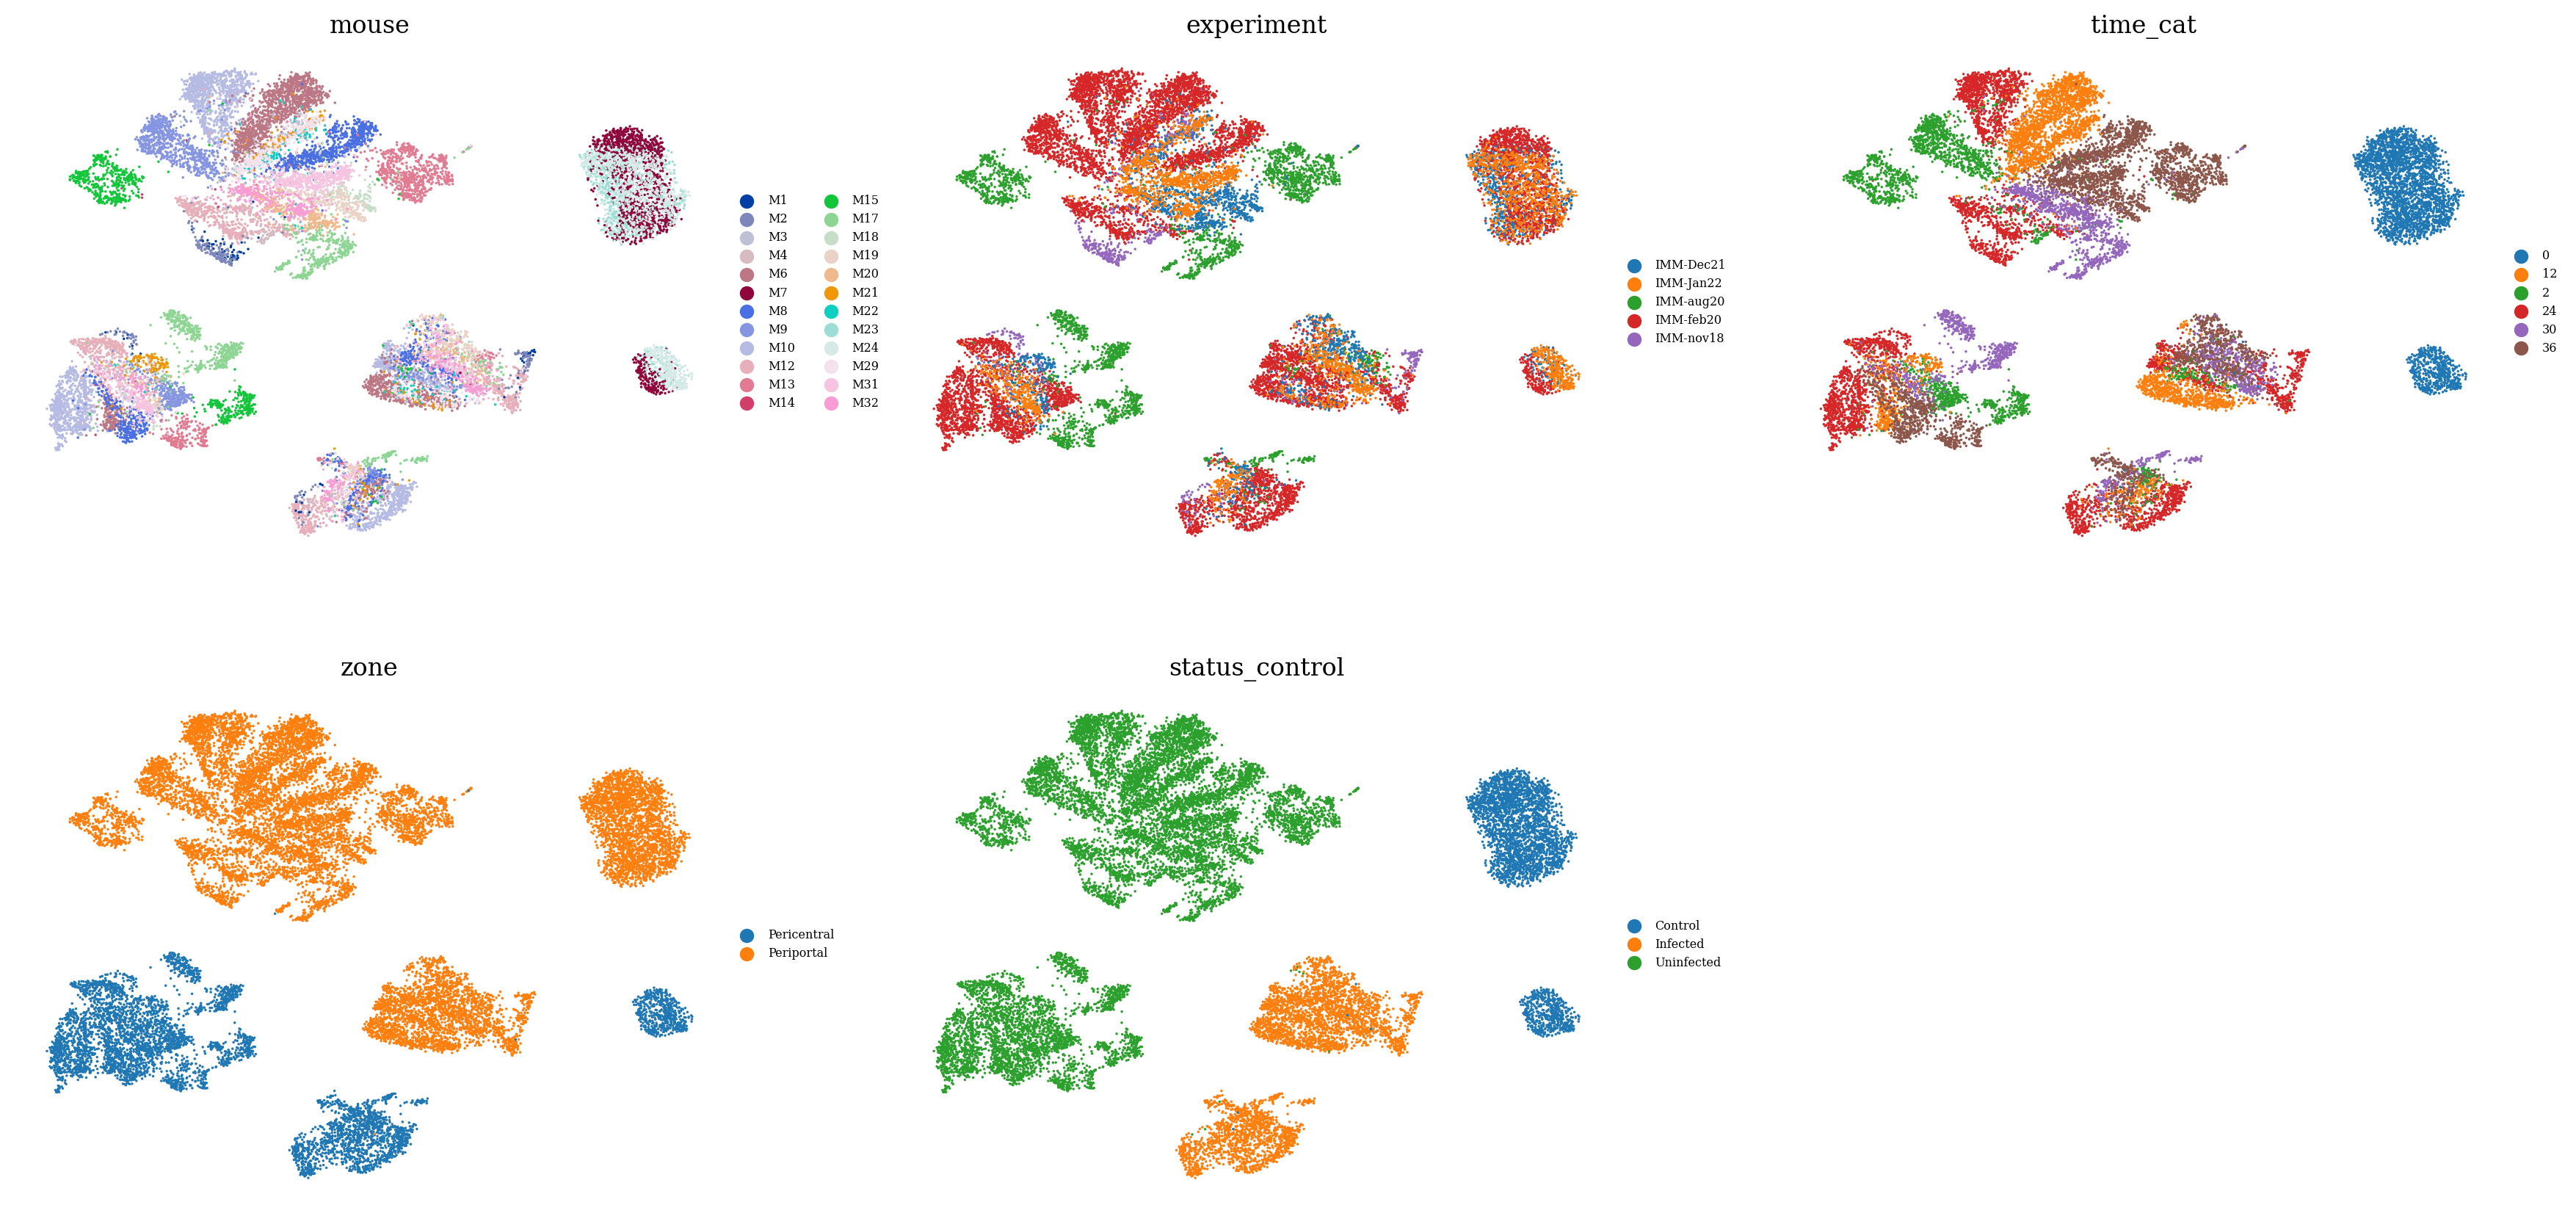

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

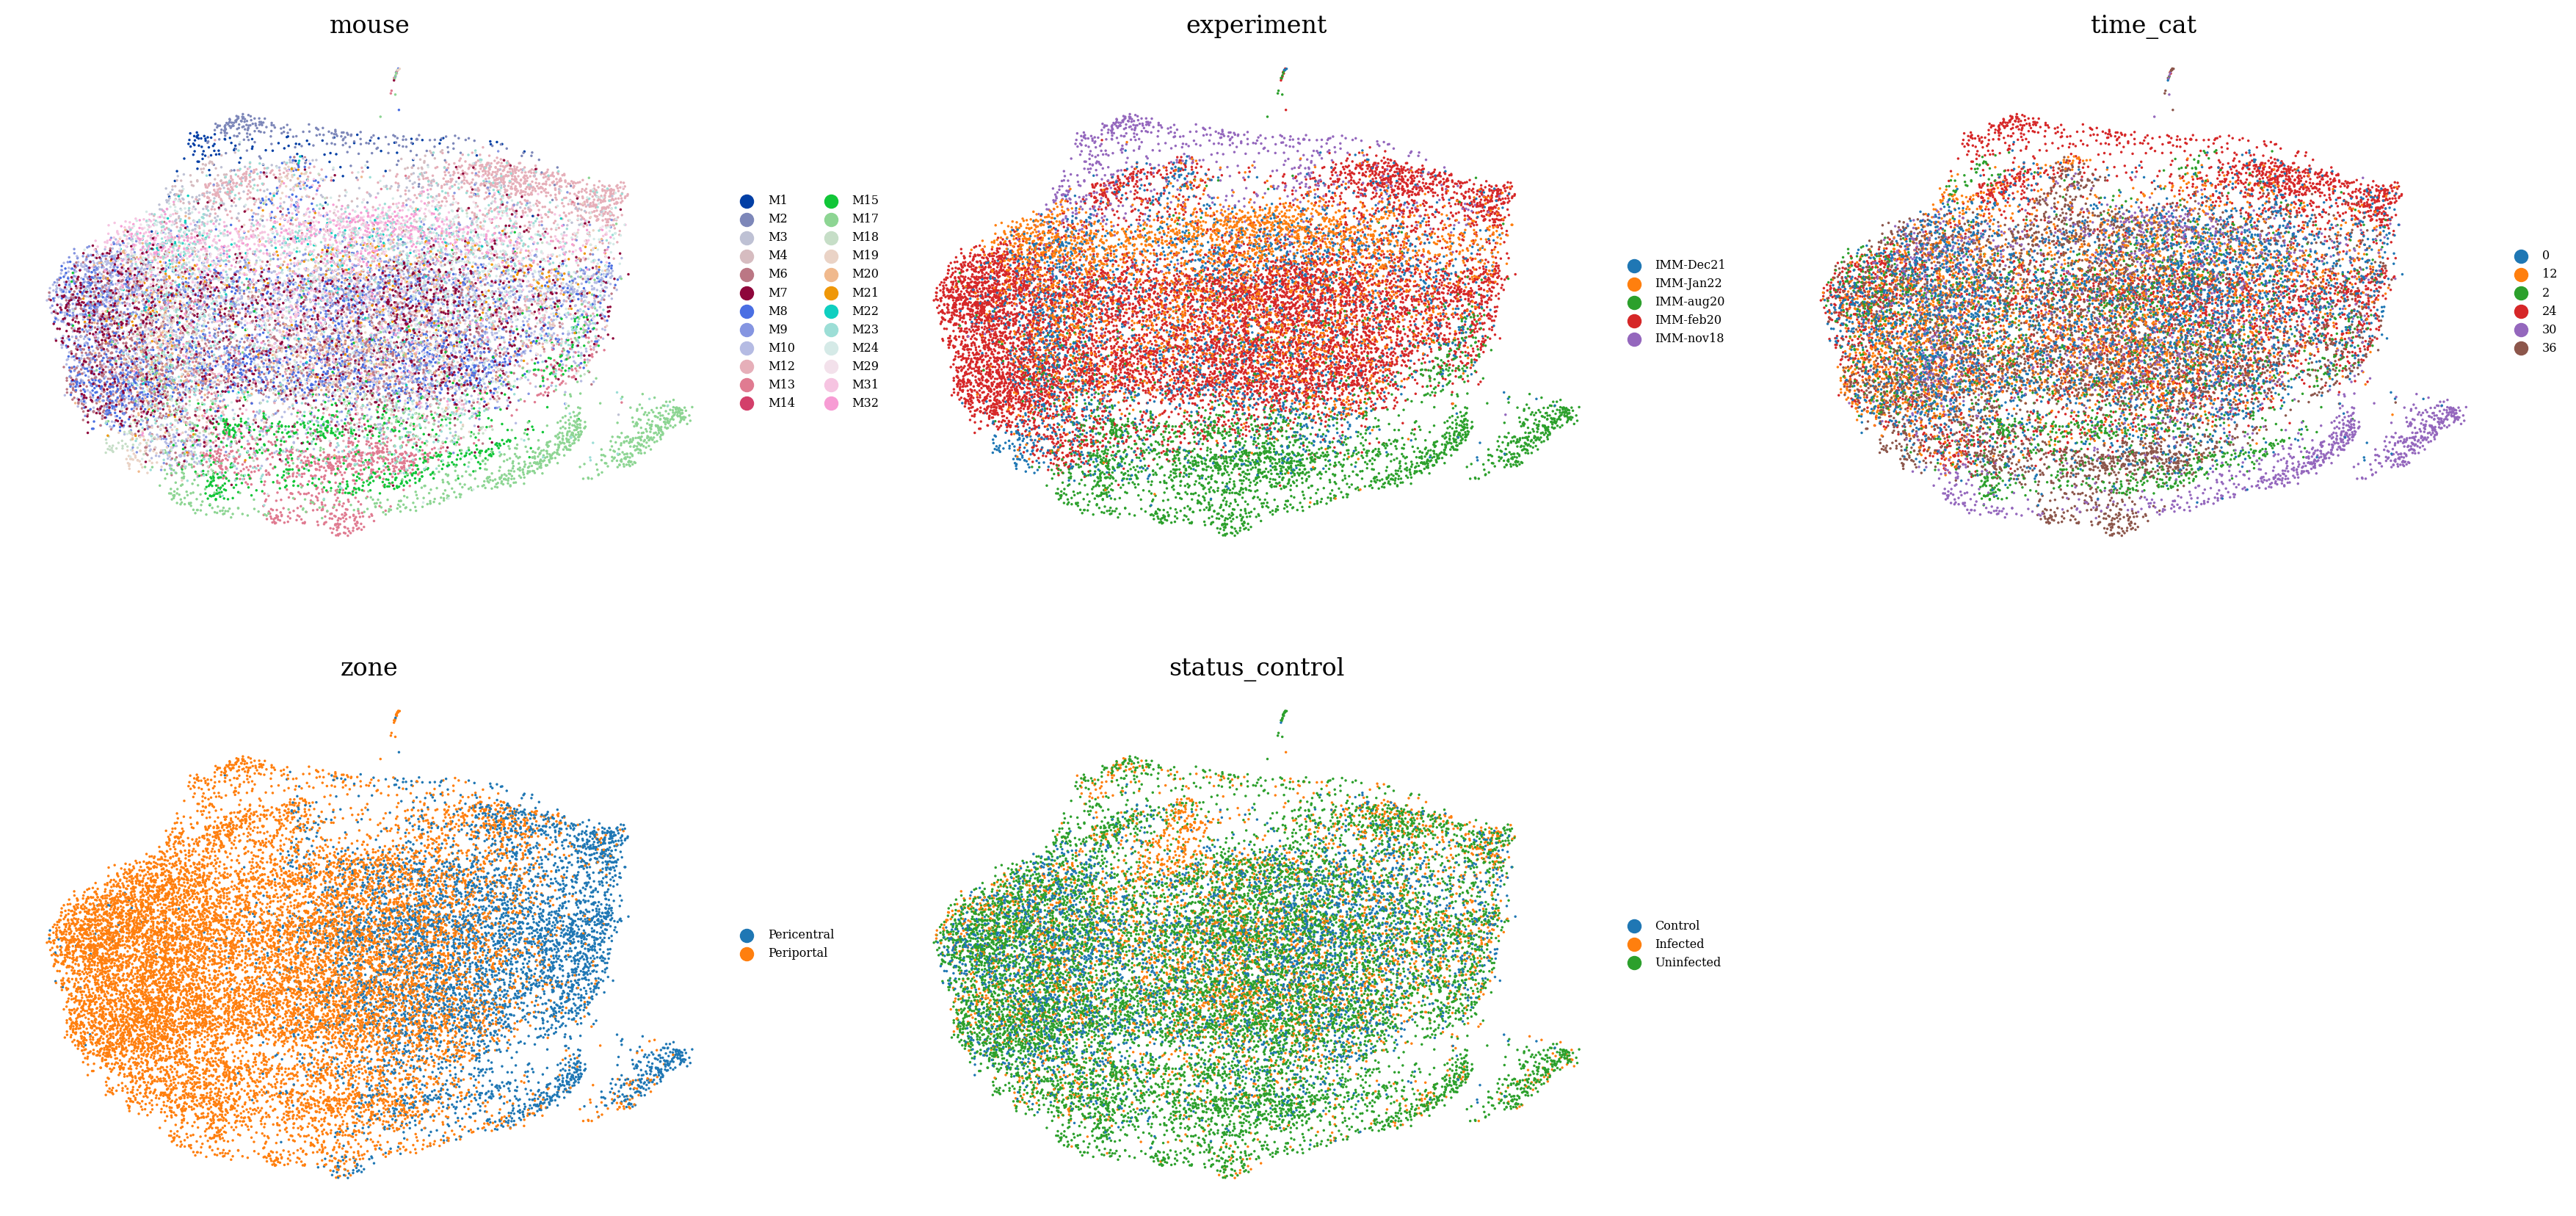

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  5%|▍         | 27/596 [00:00<00:02, 268.89it/s]

 10%|▉         | 57/596 [00:00<00:01, 286.33it/s]

 15%|█▍        | 87/596 [00:00<00:01, 291.03it/s]

 20%|█▉        | 118/596 [00:00<00:01, 295.20it/s]

 25%|██▌       | 149/596 [00:00<00:01, 297.67it/s]

 30%|███       | 179/596 [00:00<00:01, 298.04it/s]

 35%|███▌      | 210/596 [00:00<00:01, 298.86it/s]

 40%|████      | 240/596 [00:00<00:01, 299.20it/s]

 45%|████▌     | 271/596 [00:00<00:01, 300.22it/s]

 51%|█████     | 302/596 [00:01<00:00, 300.95it/s]

 56%|█████▌    | 333/596 [00:01<00:00, 301.35it/s]

 61%|██████    | 364/596 [00:01<00:00, 299.99it/s]

 66%|██████▋   | 395/596 [00:01<00:00, 300.19it/s]

 71%|███████▏  | 426/596 [00:01<00:00, 300.01it/s]

 77%|███████▋  | 457/596 [00:01<00:00, 300.12it/s]

 82%|████████▏ | 488/596 [00:01<00:00, 300.48it/s]

 87%|████████▋ | 519/596 [00:01<00:00, 300.69it/s]

 92%|█████████▏| 550/596 [00:01<00:00, 300.20it/s]

 97%|█████████▋| 581/596 [00:01<00:00, 301.43it/s]

100%|██████████| 596/596 [00:01<00:00, 298.73it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

544

576

576

608

608

640

640

672

672

704

In [23]:
np.mean(r2s)

0.9669078202911556

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)